# Satellite Capacity Forecasting with Chronos-2

[![Open In SageMaker Studio Lab](https://studiolab.sagemaker.aws/studiolab.svg)](https://studiolab.sagemaker.aws/import/github/amazon-science/chronos-forecasting/blob/main/notebooks/chronos-2-quickstart.ipynb)
[![Open In Colab](https://colab.research.google.com/assets/colab-badge.svg)](
https://colab.research.google.com/github/amazon-science/chronos-forecasting/blob/main/notebooks/chronos-2-quickstart.ipynb)



**Chronos-2** is a foundation model for time series forecasting that builds on [Chronos](https://arxiv.org/abs/2403.07815) and [Chronos-Bolt](https://aws.amazon.com/blogs/machine-learning/fast-and-accurate-zero-shot-forecasting-with-chronos-bolt-and-autogluon/). It offers significant improvements in capabilities and can handle diverse forecasting scenarios not supported by earlier models.

| Capability | Chronos | Chronos-Bolt | Chronos-2 |
|------------|---------|--------------|-----------|
| Univariate Forecasting | ✅ | ✅ | ✅ |
| Cross-learning across items | ❌ | ❌ | ✅ |
| Multivariate Forecasting | ❌ | ❌ | ✅ |
| Past-only (real/categorical) covariates | ❌ | ❌ | ✅ |
| Known future (real/categorical) covariates | 🧩 | 🧩 | ✅ |
| Fine-tuning support | ✅ | ✅ | ✅ |
| Max. Context Length | 512 | 2048 | 8192 |

We leverage Chronos-2 to perform Satellite Capacity forecasting i.e. how much bandwidth do users need at a given time in a particular spot-beam footprint. This notebook generates forecast data (bandwidth) for 24 hours at 10 min granularity (144 data points) but you can change this to any granularity as desired, based on the input training and test data sets. 

In [1]:
%pip install -q 'chronos-forecasting>=2.2'
%pip install -q 'matplotlib'

Note: you may need to restart the kernel to use updated packages.
Note: you may need to restart the kernel to use updated packages.


In [2]:
import os

# Use only 1 GPU if available
os.environ["CUDA_VISIBLE_DEVICES"] = "0"

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from chronos import BaseChronosPipeline, Chronos2Pipeline

# Load the Chronos-2 pipeline
# GPU recommended for faster inference, but CPU is also supported using device_map="cpu"
pipeline: Chronos2Pipeline = BaseChronosPipeline.from_pretrained("amazon/chronos-2", device_map="cpu")

2026-01-28 18:49:49.395656: I tensorflow/core/platform/cpu_feature_guard.cc:210] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: SSE4.1 SSE4.2 AVX AVX2 AVX512F FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.


## Forecasting with Covariates

Chronos-2 can leverage covariates to improve forecast accuracy. We demonstrate this with satellite capacity forecasting.

### Satcom Capacity Forecasting

Forecast satellite capacity bandwidth at 10 min intervals for a given spot-beam.

The structure of the CSV file provided is as follows:
- timestamp (required, timestamp column)
- airpressure (covariate)
- beam (required: item id)
- dayofweek (covariate)
- hourofday (covariate)
- mHz (required: target)

We supply more training data than test data (at least 4:1). Both are the same format however we drop the target column from the test data set since this is our target variable to forecast.

If you have very large datasets consider using [Parquet](https://docs.aws.amazon.com/sagemaker/latest/dg/autopilot-llms-finetuning-data-format.html) file formats instead.

In [3]:
import boto3
from io import StringIO

# Satellite capacity forecasting configuration
target = "mHz"  # Column name containing the values to forecast (satellite bandwidth)
prediction_length = 144  # 1 day (6 x 10 mins x 24)
id_column = "beam"  # Column identifying different time series - the spot-beam(s) we wish to forecast
timestamp_column = "timestamp"  # Column containing datetime information

timeseries_id = "SpotH12"  # Specific time series to visualize (spot beam)

# Initialize S3 client
s3_client = boto3.client('s3')

def read_csv_from_s3(bucket, key):
    """
    Read CSV file from S3 into a pandas DataFrame
    """
    try:
        # Get object from S3
        obj = s3_client.get_object(Bucket=bucket, Key=key)
        # Read CSV content
        return pd.read_csv(
            StringIO(obj['Body'].read().decode('utf-8')),
            parse_dates=[timestamp_column]
        )
    except Exception as e:
        print(f"Error reading from S3: {e}")
        raise

# S3 configuration
bucket_name = 'forecast-satcom-chronos2-capacity'     # Replace with your S3 bucket name
train_key = 'dataset/satcom-chronos2-cap_train.csv'   # Replace with your training file path in S3
test_key = 'dataset/satcom-chronos2-cap_test.csv'     # Replace with your test file path in S3

# Load historical satcom bandwidth usage and past values of covariates
satcom_context_df = read_csv_from_s3(bucket_name, train_key)
display(satcom_context_df.head())

# Load future values of covariates
satcom_test_df = read_csv_from_s3(bucket_name, test_key)
satcom_future_df = satcom_test_df.drop(columns=target)
display(satcom_future_df.head())

,timestamp,airpressure,beam,dayofweek,hourofday,mHz
0,2023-06-01 00:00:00,1049,SpotH3,3,0,238.0
1,2023-06-01 00:00:00,1021,SpotH7,3,0,283.0
2,2023-06-01 00:00:00,1030,SpotH12,3,0,235.0
3,2023-06-01 00:00:00,1035,SpotH15,3,0,227.0
4,2023-06-01 00:10:00,1007,SpotH3,3,0,247.0


,timestamp,airpressure,beam,dayofweek,hourofday
0,2023-06-13 00:00:00,1029,SpotH3,1,0
1,2023-06-13 00:00:00,1050,SpotH7,1,0
2,2023-06-13 00:00:00,1022,SpotH12,1,0
3,2023-06-13 00:00:00,1021,SpotH15,1,0
4,2023-06-13 00:10:00,1000,SpotH3,1,0


In [4]:
# Generate predictions with covariates
satcom_pred_df = pipeline.predict_df(
    satcom_context_df,
    future_df=satcom_future_df,
    prediction_length=prediction_length,
    quantile_levels=[0.1, 0.5, 0.9],
    id_column=id_column,
    timestamp_column=timestamp_column,
    target=target,
)
#display(satcom_pred_df.head(10))
display(satcom_pred_df[satcom_pred_df[id_column] == timeseries_id].head(10))

,beam,timestamp,target_name,predictions,0.1,0.5,0.9
288,SpotH12,2023-06-13 00:00:00,mHz,228.565811,212.830841,228.565811,247.508972
289,SpotH12,2023-06-13 00:10:00,mHz,229.194885,213.286285,229.194885,247.886963
290,SpotH12,2023-06-13 00:20:00,mHz,227.365372,211.986633,227.365372,244.334000
291,SpotH12,2023-06-13 00:30:00,mHz,229.713531,213.902542,229.713531,248.286285
292,SpotH12,2023-06-13 00:40:00,mHz,227.506409,212.009720,227.506409,246.479050
293,SpotH12,2023-06-13 00:50:00,mHz,232.617722,215.258301,232.617722,252.626160
294,SpotH12,2023-06-13 01:00:00,mHz,326.223999,302.912537,326.223999,348.310822
295,SpotH12,2023-06-13 01:10:00,mHz,331.136597,310.238525,331.136597,353.657990
296,SpotH12,2023-06-13 01:20:00,mHz,326.795990,306.274384,326.795990,349.811890
297,SpotH12,2023-06-13 01:30:00,mHz,333.014435,312.247040,333.014435,356.154633


In [5]:
# Visualization helper function
def plot_forecast(
    context_df: pd.DataFrame,
    pred_df: pd.DataFrame,
    test_df: pd.DataFrame,
    target_column: str,
    timeseries_id: str,
    id_column: str,
    timestamp_column: str = "timestamp",
    history_length: int = 512,
    title_suffix: str = "",
):
    ts_context = context_df.query(f"{id_column} == @timeseries_id").set_index(timestamp_column)[target_column]
    ts_pred = pred_df.query(f"{id_column} == @timeseries_id and target_name == @target_column").set_index(
        timestamp_column
    )[["0.1", "predictions", "0.9"]]
    ts_ground_truth = test_df.query(f"{id_column} == @timeseries_id").set_index(timestamp_column)[target_column]

    last_date = ts_context.index.max()
    start_idx = max(0, len(ts_context) - history_length)
    plot_cutoff = ts_context.index[start_idx]
    ts_context = ts_context[ts_context.index >= plot_cutoff]
    ts_pred = ts_pred[ts_pred.index >= plot_cutoff]
    ts_ground_truth = ts_ground_truth[ts_ground_truth.index >= plot_cutoff]

    fig = plt.figure(figsize=(12, 3))
    ax = fig.gca()
    ts_context.plot(ax=ax, label=f"historical {target_column}", color="xkcd:azure")
    ts_ground_truth.plot(ax=ax, label=f"future {target_column} (ground truth)", color="xkcd:grass green")
    ts_pred["predictions"].plot(ax=ax, label="forecast", color="xkcd:violet")
    ax.fill_between(
        ts_pred.index,
        ts_pred["0.1"],
        ts_pred["0.9"],
        alpha=0.7,
        label="prediction interval",
        color="xkcd:light lavender",
    )
    ax.axvline(x=last_date, color="black", linestyle="--", alpha=0.5)
    ax.legend(loc="upper left")
    ax.set_title(f"{target_column} forecast for {timeseries_id} {title_suffix}")
    fig.show()

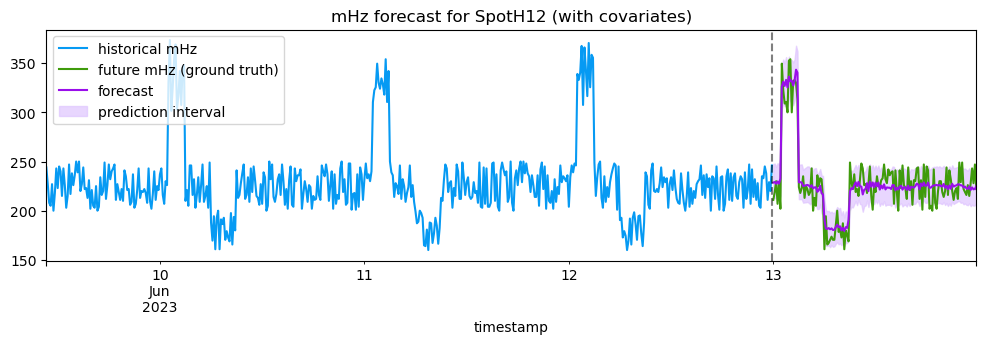

In [6]:
# Visualize forecast with covariates
plot_forecast(
    satcom_context_df,
    satcom_pred_df,
    satcom_test_df,
    target_column=target,
    timeseries_id=timeseries_id,
    id_column=id_column,
    title_suffix="(with covariates)",
)

With covariates, Chronos-2 effectively uses the weather and time of day  variables, producing significantly more accurate predictions.

## Accuracy 
### Validating the forecast

Let's analyze some of the metrics to determine how accurate our forecast is

First we analyze Weighted Absolute Percentage Error (WAPE) 
- 5% or less: "Gold Standard." Usually achieved only in highly predictable environments (e.g., utility baseload, subscription renewals).
- 5% – 10%: "Strong." Excellent for retail sales, logistics, or inventory management
- 10% – 25%: "Acceptable." Common for fast-moving consumer goods or weather-dependent data
- 25%+: "Poor." Suggests the model is missing key drivers or the data is essentially "noise."

In [7]:
def calculate_chronos_wape(predicted_df, actual_df, timeseries_id, target):
    """
    Calculate Weighted Absolute Percentage Error (WAPE) for Chronos-2 satcom forecast
    
    Parameters:
    predicted_df: DataFrame containing Chronos-2 predictions
    actual_df: DataFrame containing actual values
    timeseries_id: beam identifier
    target: target variable name
    
    Returns:
    float: WAPE value as a percentage
    """
    # Get actual and predicted values for the specific beam
    actual_values = actual_df[actual_df[id_column] == timeseries_id][target].values
    predicted_values = predicted_df[predicted_df[id_column] == timeseries_id]['predictions'].values
    
    # Calculate WAPE
    numerator = np.sum(np.abs(actual_values - predicted_values))
    denominator = np.sum(np.abs(actual_values))
    
    if denominator == 0:
        return np.sum(np.abs(actual_values - predicted_values))
        
    wape = (numerator / denominator) * 100
    
    print(f"Weighted Absolute Percentage Error (WAPE) for beam {timeseries_id}: {wape:.2f}%")
    return wape

# Calculate WAPE for your satcom forecast
wape_score = calculate_chronos_wape(
    predicted_df=satcom_pred_df,  # Your forecast DataFrame
    actual_df=satcom_test_df,  # Your test DataFrame
    timeseries_id=timeseries_id,
    target=target
)


Weighted Absolute Percentage Error (WAPE) for beam SpotH12: 5.26%


Now let's calculate the Prediction Interval Coverage Probability (PICP) which measures the percentage of actual values that fall within the prediction interval
|PICP Result|	Status|	Interpretation|
|---|---|---|
|Close to Target (e.g., 88-92%)|	Perfectly Calibrated|	The model understands the risk perfectly. Your low WAPE is highly reliable.|
|Much Lower (e.g., 60%)	| Overconfident|	The model is "narrow-minded." It thinks it's more accurate than it actually is.|
|Much Higher (e.g., 99%)|	Underconfident|	The model is being too "safe." The intervals are likely too wide to be useful for tight inventory control.|




Prediction Interval Coverage Probability Analysis for beam SpotH12
----------------------------------------------------------------------
PICP (0.1-0.9): 73.61%


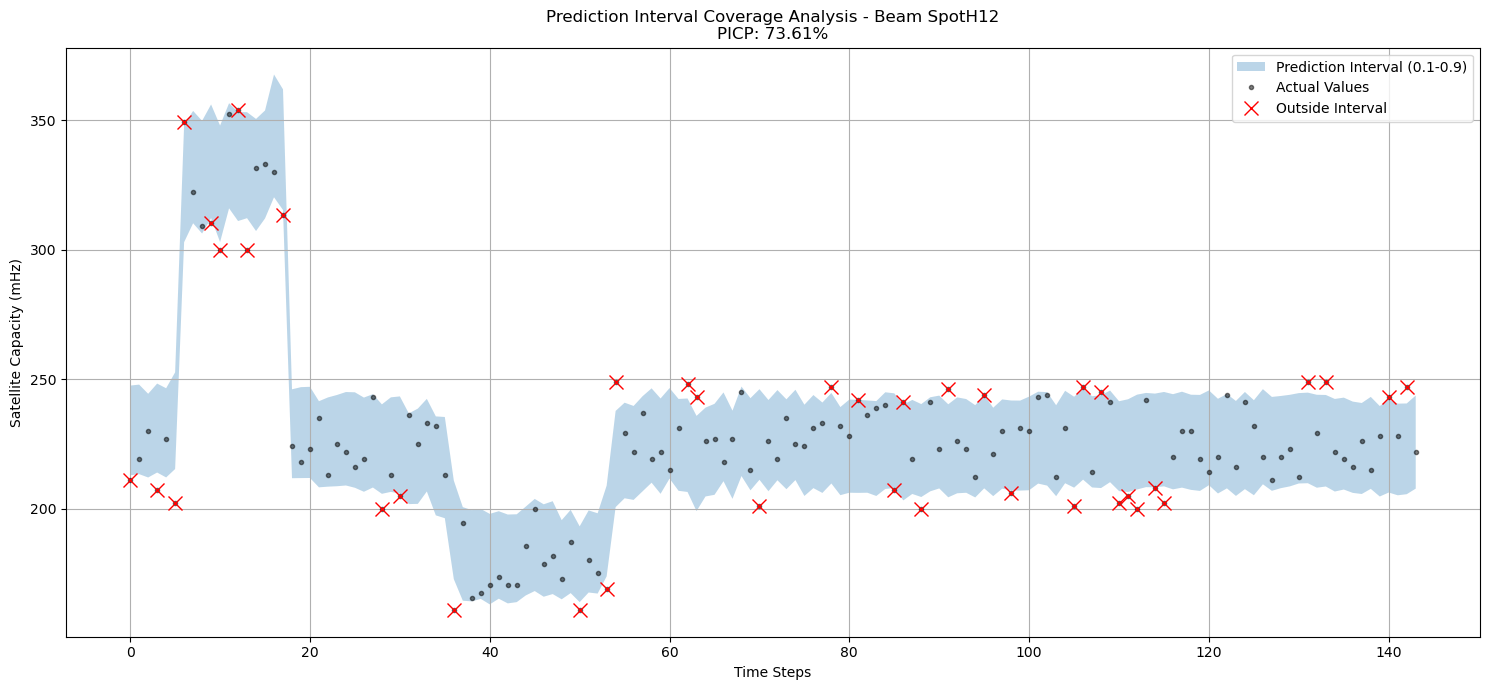


Analysis of Points Outside Prediction Interval:
Total points outside: 38 (26.39%)
Points below lower bound: 22 (15.28%)
Points above upper bound: 16 (11.11%)


In [8]:
def calculate_picp(actual_values, lower_bound, upper_bound):
    """
    Calculate Prediction Interval Coverage Probability (PICP)
    
    PICP measures the percentage of actual values that fall within the prediction interval
    
    Parameters:
    actual_values: array of actual values
    lower_bound: array of lower bound predictions (e.g., P10)
    upper_bound: array of upper bound predictions (e.g., P90)
    
    Returns:
    float: PICP value as a percentage
    """
    within_bounds = np.sum((actual_values >= lower_bound) & (actual_values <= upper_bound))
    total_points = len(actual_values)
    picp = (within_bounds / total_points) * 100
    return picp

def analyze_prediction_intervals(predicted_df, actual_df, timeseries_id, target, 
                              lower_quantile='p10', upper_quantile='p90'):
    """
    Analyze prediction intervals using PICP and visualize results
    
    Parameters:
    predicted_df: DataFrame containing predictions with quantiles
    actual_df: DataFrame containing actual values
    timeseries_id: beam identifier
    target: target variable name
    lower_quantile: column name for lower bound
    upper_quantile: column name for upper bound
    """
    # Get actual values and predictions for the specific beam
    actual_values = actual_df[actual_df[id_column] == timeseries_id][target].values
    lower_bound = predicted_df[predicted_df[id_column] == timeseries_id][lower_quantile].values
    upper_bound = predicted_df[predicted_df[id_column] == timeseries_id][upper_quantile].values
    
    # Calculate PICP
    picp_score = calculate_picp(actual_values, lower_bound, upper_bound)
    
    # Print results
    print(f"\nPrediction Interval Coverage Probability Analysis for beam {timeseries_id}")
    print("-" * 70)
    print(f"PICP ({lower_quantile}-{upper_quantile}): {picp_score:.2f}%")
    
    # Visualize prediction intervals
    plt.figure(figsize=(15, 7))
    time_index = range(len(actual_values))
    
    # Plot prediction interval
    plt.fill_between(time_index, lower_bound, upper_bound, 
                    alpha=0.3, label=f'Prediction Interval ({lower_quantile}-{upper_quantile})')
    
    # Plot actual values
    plt.plot(time_index, actual_values, 'k.', label='Actual Values', alpha=0.5)
    
    # Highlight points outside the prediction interval
    outside_interval = ~((actual_values >= lower_bound) & (actual_values <= upper_bound))
    if np.any(outside_interval):
        plt.plot(np.array(time_index)[outside_interval], 
                actual_values[outside_interval], 
                'rx', label='Outside Interval', 
                markersize=10)
    
    plt.title(f'Prediction Interval Coverage Analysis - Beam {timeseries_id}\nPICP: {picp_score:.2f}%')
    plt.xlabel('Time Steps')
    plt.ylabel(f'Satellite Capacity ({target})')
    plt.legend()
    plt.grid(True)
    plt.tight_layout()
    plt.show()
    
    # Additional analysis of points outside the interval
    if np.any(outside_interval):
        print("\nAnalysis of Points Outside Prediction Interval:")
        print(f"Total points outside: {np.sum(outside_interval)} ({(np.sum(outside_interval)/len(actual_values)*100):.2f}%)")
        print(f"Points below lower bound: {np.sum(actual_values < lower_bound)} ({(np.sum(actual_values < lower_bound)/len(actual_values)*100):.2f}%)")
        print(f"Points above upper bound: {np.sum(actual_values > upper_bound)} ({(np.sum(actual_values > upper_bound)/len(actual_values)*100):.2f}%)")
    
    return {
        'picp': picp_score,
        'outside_interval': np.sum(outside_interval),
        'below_lower': np.sum(actual_values < lower_bound),
        'above_upper': np.sum(actual_values > upper_bound)
    }

# Calculate and visualize PICP
picp_results = analyze_prediction_intervals(
    predicted_df=satcom_pred_df,      # Your forecast DataFrame with quantile predictions
    actual_df=satcom_test_df,      # Your test DataFrame
    timeseries_id=timeseries_id,
    target=target,
    lower_quantile="0.1",         # Adjust these quantiles as needed
    upper_quantile="0.9"
)
